In [345]:
%env DGLBACKEND=tensorflow
import dgl

env: DGLBACKEND=tensorflow


In [346]:
dataset = dgl.data.CiteseerGraphDataset()

  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [224]:
graph = dataset[0]
adj = graph.adjacency_matrix()

In [464]:
features = graph.ndata['feat']
labels = graph.ndata['label']
train_mask = graph.ndata['train_mask']
test_mask = graph.ndata['test_mask']

x = features[train_mask]
tx = features[test_mask]
allx = features[:]
y = labels[train_mask]
ty = labels[test_mask]
ally = labels[:]
train_mask

tensor([False,  True, False,  ..., False, False,  True])

In [506]:
import tensorflow as tf

class GCN_Layer(tf.keras.layers.Layer):
    def __init__(self, adjacency_matrix, input_dim, output_dim):
        super(GCN_Layer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.adjacency_matrix = adjacency_matrix
        self.a_cap = tf.linalg.normalize(self.adjacency_matrix.to_dense() + tf.eye(self.adjacency_matrix.shape[0]), axis=0)[0]
        self.w = self.add_weight(shape=(self.input_dim, self.output_dim),
                               initializer='random_normal',
                               trainable=True)
    
    def call(self, inputs):
        return tf.linalg.matmul(tf.linalg.matmul(self.a_cap, inputs), self.w)

In [514]:
class GCN_Model(tf.keras.Model):
    def __init__(self, adjacency_matrix, imput_dim, output_dim):
        super(GCN_Model, self).__init__()
        self.layer1 = GCN_Layer(adjacency_matrix, imput_dim, 8*16)
        self.layer2 = GCN_Layer(adjacency_matrix, 8*16, output_dim)

    def call(self, inputs):
        x1 = tf.keras.activations.relu(self.layer1(inputs))
        x2 = tf.keras.activations.softmax(self.layer2(x1))
        return x2
#         return torch.tensor(tf.math.reduce_max(x2, axis=1).numpy())

In [ ]:
import numpy as np
import torch
model = GCN_Model(adj, features.size()[1], labels.unique().size()[0])
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

def loss(model, x, y, train_mask, training):
#     y_pre = model(x)
    return loss_object(y_true=y, y_pred=model(x))

def grad(model, inputs, targets, train_mask):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, train_mask, training=True)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)
    
train_loss_results = []
loss_list=[]
acc_list=[]
all_logits=[]
train_accuracy_results=[]
for epoch in range(200):
    print(epoch)
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    loss_value, grads = grad(model, tf.cast(features, dtype=tf.float32), labels, train_mask)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    epoch_accuracy.update_state(labels, model(features, training=True))
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

0
Epoch 000: Loss: 0.000, Accuracy: 14.608%
1
Epoch 001: Loss: 0.000, Accuracy: 14.728%
2
Epoch 002: Loss: 0.000, Accuracy: 14.758%
3
Epoch 003: Loss: 0.000, Accuracy: 14.758%
4
Epoch 004: Loss: 0.000, Accuracy: 14.758%
5
Epoch 005: Loss: 0.000, Accuracy: 14.758%
6
Epoch 006: Loss: 0.000, Accuracy: 14.758%
7
Epoch 007: Loss: 0.000, Accuracy: 14.788%
8
Epoch 008: Loss: 0.000, Accuracy: 14.788%
9
Epoch 009: Loss: 0.000, Accuracy: 14.848%
10
Epoch 010: Loss: 0.000, Accuracy: 14.878%
11
Epoch 011: Loss: 0.000, Accuracy: 14.938%
12
Epoch 012: Loss: 0.000, Accuracy: 14.938%
13
Epoch 013: Loss: 0.000, Accuracy: 14.938%
14
Epoch 014: Loss: 0.000, Accuracy: 14.938%
15
Epoch 015: Loss: 0.000, Accuracy: 15.059%
16
Epoch 016: Loss: 0.000, Accuracy: 15.089%
17
Epoch 017: Loss: 0.000, Accuracy: 15.119%
18
Epoch 018: Loss: 0.000, Accuracy: 15.179%
19
Epoch 019: Loss: 0.000, Accuracy: 15.179%
20
Epoch 020: Loss: 0.000, Accuracy: 15.269%
21
Epoch 021: Loss: 0.000, Accuracy: 15.329%
22
Epoch 022: Loss: 

Text(0, 0.5, 'Accuracy')

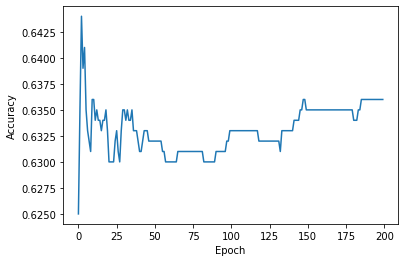

In [122]:
import matplotlib.pyplot as plt
plt.plot(acc_list)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')